In [68]:
# Import the Relevant Libraries
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Importing the relevant files
train_file = '../../Data/NCBItrainset_corpus.txt'
dev_file = '../../Data/NCBIdevelopset_corpus.txt'
model_name = '../../Models/LSTM_Attention_NER_model.pth'

In [69]:
# Reading the dataset file
def read_dataset(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

def parse_dataset(lines):
    paragraphs = []
    paragraph = []

    for line in lines:
        line = line.strip()
        if line:
            paragraph.append(line)
        else:
            if paragraph:
                paragraphs.append(paragraph)
                paragraph = []

    if paragraph:
        paragraphs.append(paragraph)

    return paragraphs

In [70]:
# Parsing the different paragraphs and annotations
def parse_paragraph(paragraph):
    sentences = []
    annotations = []
    sentence = []

    for line in paragraph:
        if re.match(r'^\d+\|\w\|', line):
            sentence.extend(line.split('|')[2].split())

        elif re.match(r'^\d+\t\d+\t\d+\t', line):
            start, end = int(line.split("\t")[1]), int(line.split("\t")[2])
            annotations.append((start, end, line.split("\t")[3], line.split("\t")[4]))

    if sentence:
        sentences.append(sentence)
    return sentences, annotations

In [71]:
# Data Labelling
def tag_annotations(sentences, annotations):
    tagged_sentences = []
    char_count = 0

    for sentence in sentences:
        tags = ['O'] * len(sentence)    # Initialize all tags at "O"
        word_starts = []
        word_ends = []
        char_pos = 0

        for word in sentence:
            word_starts.append(char_pos)
            char_pos += len(word)
            word_ends.append(char_pos)
            char_pos += 1               # WhiteSpace Character

        '''
        Based on the character limits, the annotations are assigned
        A custom IO tagging scheme is used
        Labels are assigned on the basis of disease label in annotations
        '''

        for start, end, disease_info, label in annotations:
            for i, (word_start, word_end) in enumerate(zip(word_starts, word_ends)):
                if word_start >= start and word_end <= end:
                    tags[i] = 'I-' + label
                elif word_start < start < word_end or word_start < end < word_end:
                    tags[i] = 'I-' + label

        tagged_sentences.append((sentence, tags))

    return tagged_sentences

In [72]:
# Parsing the dataset file
lines = read_dataset(train_file)
paragraphs = parse_dataset(lines)

all_sentences = []
all_tags = []

for paragraph in paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        all_sentences.append(sentence)
        all_tags.append(tags)

In [73]:
dev_lines = read_dataset(dev_file)
dev_paragraphs = parse_dataset(dev_lines)
dev_all_sentences, dev_all_tags = [], []
for dev_paragraph in dev_paragraphs:
    dev_s, dev_a = parse_paragraph(dev_paragraph)
    dev_tagged_sentences = tag_annotations(dev_s, dev_a)
    for dev_sentence, dev_tag in dev_tagged_sentences:
        dev_all_sentences.append(dev_sentence)
        dev_all_tags.append(dev_tag)

In [74]:
# Define Dataset class
class LSTM_Attention_NERDataset(Dataset):
    def __init__(self, sentences, tags, word_encoder, tag_encoder, unknown_token='<UNK>'):
        self.sentences = sentences
        self.tags = tags
        self.word_encoder = word_encoder
        self.tag_encoder = tag_encoder
        self.unknown_token = unknown_token

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]

        sentence_encoded = [self.word_encoder.get(word, self.word_encoder[self.unknown_token]) for word in sentence]
        tags_encoded = self.tag_encoder.transform(tags)

        return torch.tensor(sentence_encoded), torch.tensor(tags_encoded, dtype=torch.long)

In [75]:
# Prepare data
all_words = [word for sentence in all_sentences for word in sentence]
all_tags_flat = [tag for tags in all_tags for tag in tags]

word_encoder = {word: idx for idx, word in enumerate(set(all_words))}
unknown_token = '<UNK>' 
word_encoder[unknown_token] = len(word_encoder)  # Add unknown token
# Done to prevent KeyError as some words might be out of vocabulary in testing dataset

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

dataset = LSTM_Attention_NERDataset(all_sentences, all_tags, word_encoder, tag_encoder, unknown_token)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda x: x)

dev_dataset = LSTM_Attention_NERDataset(dev_all_sentences, dev_all_tags, word_encoder, tag_encoder, unknown_token)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)

In [76]:
# Defining the Global Attention class
class Attention (nn.Module):
    def __init__ (self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # Softmax converts it into a Probability distribution so that the weights are between 0 and 1
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        weighted_output = lstm_output * attention_weights  # (batch_size, seq_len, hidden_dim)
        return weighted_output # (batch_size, hidden_dim)

class Attention_LSTM_NER_Model(nn.Module):
    def __init__ (self, vocab_size, tagset_size, embedding_dim = 128, hidden_dim = 128):
        super(Attention_LSTM_NER_Model, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.attention = Attention(hidden_dim)

    def forward(self, i):
        emb = self.embedding(i)
        lstm_out , _ = self.lstm(emb)
        att_out = self.attention(lstm_out)
        tag_space = self.fc(att_out)
        return tag_space

In [77]:
# Defining the model characteristics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Attention_LSTM_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

cuda


In [78]:
# Function for plotting (to be used to visualize the training loss and validation loss)
# Used to figure if the mdoel is underfitting or overfitting
def graph_plot(title, x_label, y_label, x_data, y_data, z_data, color = 'blue', linestyle = '-'):
    plt.plot(x_data, y_data, color = color, linestyle = linestyle)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_data, z_data, color = 'r', linestyle = '-')
    plt.legend()
    plt.savefig("../../Graphs/LSTM_Attention.png", bbox_inches = 'tight')

In [79]:
# Storing the average training and validation losses
loss_dic = {}
valid_loss_dic = {}

model.train()
# Training the Model
for epoch in range(420):
    total_loss = 0
    total_valid_loss = 0

    # Training phase
    model.train()
    for batch in dataloader:
        sentences, tags = zip(*batch)
        sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
        tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)
            loss = criterion(outputs, tags)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(dataloader)

    # Validation Dataset
    # model.eval()
    with torch.no_grad():
        for batch in dev_dataloader:
            dev_sentence, dev_tag = zip(*batch)
            dev_sentence = torch.nn.utils.rnn.pad_sequence(dev_sentence, batch_first=True).to(device)
            dev_tag = torch.nn.utils.rnn.pad_sequence(dev_tag, batch_first=True, padding_value=-100).to(device)

            with torch.cuda.amp.autocast():
                dev_outputs = model(dev_sentence)
                dev_outputs = dev_outputs.view(-1, dev_outputs.shape[-1])
                dev_tag = dev_tag.view(-1)
                valid_loss = criterion(dev_outputs, dev_tag)
                total_valid_loss += valid_loss.item()
    
    avg_valid_loss = total_valid_loss / len(dev_dataloader)

    # Update learning rate scheduler
    scheduler.step(avg_train_loss)

    # Print and store losses
    print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
    loss_dic[epoch] = avg_train_loss
    valid_loss_dic[epoch] = avg_valid_loss

Epoch 1, Average Training Loss: 1.5098, Validation Loss: 1.4523
Epoch 2, Average Training Loss: 1.4045, Validation Loss: 1.3572
Epoch 3, Average Training Loss: 1.3112, Validation Loss: 1.2650
Epoch 4, Average Training Loss: 1.2276, Validation Loss: 1.1913
Epoch 5, Average Training Loss: 1.1518, Validation Loss: 1.1193
Epoch 6, Average Training Loss: 1.0807, Validation Loss: 1.0597
Epoch 7, Average Training Loss: 1.0129, Validation Loss: 0.9751
Epoch 8, Average Training Loss: 0.9549, Validation Loss: 0.9233
Epoch 9, Average Training Loss: 0.8949, Validation Loss: 0.8764
Epoch 10, Average Training Loss: 0.8466, Validation Loss: 0.8279
Epoch 11, Average Training Loss: 0.8012, Validation Loss: 0.7767
Epoch 12, Average Training Loss: 0.7584, Validation Loss: 0.7512
Epoch 13, Average Training Loss: 0.7196, Validation Loss: 0.7250
Epoch 14, Average Training Loss: 0.6865, Validation Loss: 0.6790
Epoch 15, Average Training Loss: 0.6459, Validation Loss: 0.6468
Epoch 16, Average Training Loss: 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


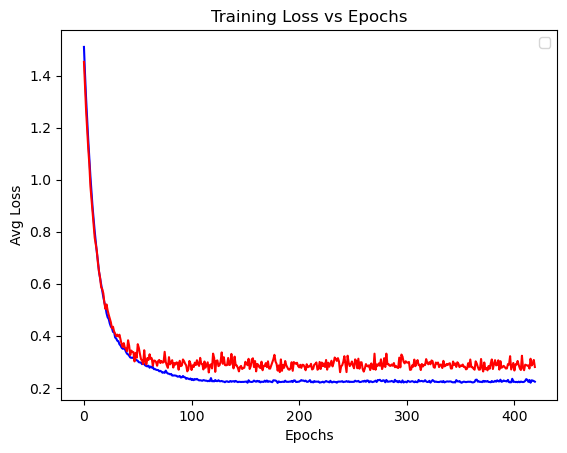

In [80]:
graph_plot("Training Loss vs Epochs", "Epochs", "Avg Loss", list(loss_dic.keys()), list(loss_dic.values()), list(valid_loss_dic.values()))

In [81]:
# Saving the model as a .pth file
torch.save(model.state_dict(), model_name)

In [82]:
# Testing the model

# Load the test dataset
test_file = '../../Data/NCBItestset_corpus.txt'
test_lines = read_dataset(test_file)
test_paragraphs = parse_dataset(test_lines)

In [83]:
# Parsing and storing the test dataset
test_sentences = []
test_tags = []

for paragraph in test_paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        test_sentences.append(sentence)
        test_tags.append(tags)

In [84]:
# Importing the model file
model = Attention_LSTM_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

Attention_LSTM_NER_Model(
  (lstm): LSTM(128, 128, batch_first=True)
  (embedding): Embedding(14805, 128)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=False)
  )
)

In [85]:
# Prepare the test data
test_dataset = LSTM_Attention_NERDataset(test_sentences, test_tags, word_encoder, tag_encoder, '<UNK>')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: x)

# Evaluate the model
all_true_labels = []
all_pred_labels = []

result = "../../Result/TestResults_AttentionLSTM_NER.txt"
with open(result, 'w') as t_file:
    with torch.no_grad():
        for batch in test_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)

            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels = tags.cpu().numpy()

            mask = true_labels != -100
            pred_labels = predictions[mask]
            true_labels = true_labels[mask]

            pred_labels_decoded = tag_encoder.inverse_transform(pred_labels)
            true_labels_decoded = tag_encoder.inverse_transform(true_labels)

            for true_label, pred_label in zip(true_labels_decoded, pred_labels_decoded):
                t_file.write(f'True: {true_label}, Pred: {pred_label}\n')
                all_true_labels.append(true_label)
                all_pred_labels.append(pred_label)

# Printing classification report
report = classification_report(all_true_labels, all_pred_labels)
print (report)

c:\Users\Adit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

I-CompositeMention       0.00      0.00      0.00        89
    I-DiseaseClass       0.00      0.00      0.00       255
        I-Modifier       0.00      0.00      0.00       367
 I-SpecificDisease       1.00      0.00      0.00      1090
                 O       0.91      1.00      0.95     18601

          accuracy                           0.91     20402
         macro avg       0.38      0.20      0.19     20402
      weighted avg       0.88      0.91      0.87     20402



c:\Users\Adit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
